In [32]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from train.global_p import match_label_fou_clean2, match_label_video
from utils import get_images_labels , read_mean_std, fold_batches
from utils import imread_rgb, mean_avg_precision, avg_precision, scale_cv
from model.nn_utils import *
from model.siamese import *
from model.custom_modules import *
from os import path
import cv2
import random

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [33]:
trainSetPath = 'data/pre_proc/fourviere_video2_448'
testSetPath = 'data/pre_proc/fourviere_video2_448/test'
mean_std_file = 'data/fourviere_448_train_ms.txt'
image_size = (3, 224, 224)
fit_size = False
cnn_model = models.resnet152
feature_size = (7, 7)
out_size = 1000 # 7 * 7 * 2048  # 6 * 6 * 256
conv_features = False

In [34]:
m, s = read_mean_std(mean_std_file)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m, s)])

def get_embeddings(net, dataset, out_size):
    C, H, W = image_size

    def batch(last, i, is_final, batch):
        embeddings = last
        n = len(batch)
        test_in = torch.Tensor(n, C, H, W).cuda()
        for j in range(n):
            test_in[j] = batch[j][0]

        out = net(Variable(test_in, volatile=True))
        out = out.view(out.size(0), out_size)
        for j, o in enumerate(out.data):
            embeddings[i + j] = o / (o.norm() + 1e-10)
        return embeddings
    init = torch.Tensor(len(dataset), out_size)
    return fold_batches(batch, init, dataset, 32)

def pre_proc(im_o):
    if fit_size:
        im_o = cv2.resize(im_o, (image_size[1], image_size[2]), cv2.INTER_CUBIC)
    return im_o

In [35]:
trainSetFull = get_images_labels(trainSetPath, match_label_video)
testSetFull = get_images_labels(testSetPath, match_label_video)

labels = sorted(list(set(lab for im, lab in trainSetFull)))
print(len(trainSetFull), len(testSetFull), len(labels))
print(labels)

(1815, 624, 161)
['A_001', 'A_002', 'A_003', 'A_004', 'A_005', 'A_006', 'A_007', 'A_008', 'A_009', 'A_010', 'A_011', 'A_012', 'A_013', 'A_014', 'A_015', 'A_016', 'A_017', 'A_018', 'A_020', 'A_021', 'A_024', 'A_025', 'A_026', 'A_028', 'A_029', 'A_030', 'A_031', 'A_032', 'A_033', 'A_034', 'A_035', 'A_036', 'A_037', 'A_039', 'A_040', 'A_042', 'A_043', 'A_044', 'A_045', 'A_046', 'A_047', 'A_048', 'A_049', 'A_051', 'A_052', 'A_053', 'A_054', 'A_055', 'A_056', 'A_057', 'A_058', 'A_059', 'A_060', 'A_061', 'A_062', 'A_063', 'A_064', 'B_021', 'B_028', 'B_032', 'B_038', 'B_046', 'B_048', 'B_054', 'B_055', 'B_059', 'B_060', 'B_061', 'B_063', 'B_064', 'B_065', 'B_067', 'B_069', 'B_073', 'B_078', 'B_088', 'C_001', 'C_003', 'C_004', 'C_005', 'C_006', 'C_009', 'C_010', 'C_012', 'C_014', 'C_015', 'C_023', 'C_024', 'C_028', 'C_029', 'C_030', 'C_031', 'C_038', 'C_039', 'C_047', 'C_050', 'C_052', 'C_057', 'C_062', 'C_063', 'C_066', 'C_087', 'C_100', 'C_101', 'D_001', 'D_002', 'D_006', 'D_008', 'D_009', '

In [ ]:
# first section: test feature net on a given dataset (print avg precision values/mAP etc.)

In [7]:
trainSet, testSet = [], []
for im, lab in trainSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        trainSet.append((im_out, lab, im))
for im, lab in testSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        testSet.append((im_out, lab, im))
print(len(trainSet))
print(len(testSet))

3245
165


In [8]:
feature_net = cnn_model(pretrained=True)
if conv_features and isinstance(feature_net, TuneClassif):
    feature_net.classifier = nn.Sequential()
    feature_net.feature_reduc = nn.Sequential()
elif conv_features and (cnn_model is models.resnet152 or cnn_model is models.resnet101):
    feature_net.avgpool = nn.Sequential()
    feature_net.fc = nn.Sequential()
elif conv_features:
    feature_net.classifier = nn.Sequential()
feature_net = feature_net.cuda().eval()

In [13]:
test_embeddings = get_embeddings(feature_net, testSet, out_size)
ref_embeddings = get_embeddings(feature_net, trainSet, out_size)
sim = torch.mm(test_embeddings, ref_embeddings.t())
maxSim, maxIdx = sim.max(1)
maxLabel = []
for i in maxIdx:
    # get label from ref set which obtained highest score
    maxLabel.append(trainSet[i[0]][1])
correct = sum(testLabel == maxLabel[j] for j, (_, testLabel, _) in enumerate(testSet))
total = len(testSet)

In [17]:
print(correct, '/', total, '->', float(correct)/total)
print(mean_avg_precision(sim, testSet, trainSet))
for i in range(sim.size(0)):
    print(testSet[i][1], avg_precision(sim, i, testSet, trainSet), sum(testSet[i][1] == trainLab for _, trainLab, _ in trainSet))

(106, '/', 165, '->', 0.6424242424242425)
0.315586555614
('10A', 0.33085317460317454, 4)
('10C', 0.04953938429638845, 8)
('10J', 0.22865674508007558, 11)
('10J', 0.344987240863682, 11)
('11A', 0.2714499971758117, 10)
('11C', 0.003200937852420862, 5)
('11C', 0.701005291005291, 5)
('11F', 0.12372996657400451, 10)
('11J', 0.8178039215686275, 5)
('11O', 0.00405372169203168, 5)
('12A', 0.5374120434126828, 10)
('12D', 0.38979162326597544, 3)
('12E', 0.10045822140260237, 10)
('12F', 0.15533842138615572, 8)
('12G', 0.3800110337979898, 14)
('12G', 0.14060448682108817, 14)
('12G', 0.0033578123702988866, 14)
('12I', 0.4128973143111086, 10)
('12K', 0.17647147490896736, 6)
('12P', 0.10484610550538978, 14)
('12P', 0.37521109916548123, 14)
('13A', 0.002185663709490024, 10)
('14M', 0.43883334453898554, 5)
('15F', 0.7514285714285713, 5)
('15G', 0.5161396156952899, 5)
('16C', 0.00387619265503143, 10)
('16F', 0.1959031642756657, 10)
('16O', 0.16404465342641644, 10)
('1C', 0.00328856143650887, 5)
('1F', 0

In [ ]:
# in this section: output embeddings conforming to gordo's test program

In [17]:
import numpy as np
import os

out_size = 2048
full_dataset_path = 'data/pre_proc/fourviere_video_448/jpg'
queries_path = '../gordo_retrieval/datasets/fourviere_video/lab'
match = match_label_video

In [18]:
def get_embeddings(net, dataset, out_size):
    def batch(last, i, is_final, batch):
        print(i)
        embeddings = last
        test_in = batch[0][0].unsqueeze(0).cuda()
        out = net(Variable(test_in, volatile=True))
        embeddings[i] = out.data[0]
        return embeddings
    init = torch.Tensor(len(dataset), out_size)
    return fold_batches(batch, init, dataset, 1)

In [19]:
queries = []
for e in np.sort(os.listdir(queries_path)):
    if e.endswith('_query.txt'):
        queries.append(e[:-len('_query.txt')])
queries = sorted(queries)
full_dataset, ref_dataset = [], []
i = 0
for im in np.sort(os.listdir(full_dataset_path)):
    print(i)
    i+=1
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, im))))
    lab = match(im)
    full_dataset.append((im_o, lab, im))
    if path.splitext(path.basename(im))[0] not in queries:
        ref_dataset.append((im_o, lab, im))
query_set = []
for name in queries:
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, name + '.jpg'))))
    query_set.append((im_o, match(name), name))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
class_net = TuneClassifSub(cnn_model(pretrained=True), len(labels), feature_size)
# class_net.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
# class_net.cuda().eval()
siam_net = RegionDescriptorNet(class_net, 6, out_size, feature_size)
siam_net.load_state_dict(torch.load('data/final_siam_sub/fou_resnet152.pth.tar'))
siam_net.cuda().eval()
query_embeddings = get_embeddings(siam_net, query_set, out_size)
dataset_embeddings = get_embeddings(siam_net, full_dataset, out_size)
ref_embeddings = get_embeddings(siam_net, ref_dataset, out_size)
np.save('data/fourviere_video_S800_L2_queries.npy', query_embeddings.numpy())
np.save('data/fourviere_video_S800_L2_dataset.npy', dataset_embeddings.numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
sim = torch.mm(query_embeddings, ref_embeddings.t())
print(mean_avg_precision(sim, query_set, ref_dataset))
for i in range(sim.size(0)):
    print(query_set[i][1], avg_precision(sim, i, query_set, ref_dataset), sum(query_set[i][1] == ref_label for _, ref_label, _ in ref_dataset))

In [27]:
# in this section: visualize maximal activations of a fine-tuned classification net

In [36]:
feature_net1 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net1.load_state_dict(torch.load('data/final_classif_ft/fou2_resnet152.pth.tar'))
feature_net1 = feature_net1.eval().cuda()
feature_net2 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net2.load_state_dict(torch.load('data/final_classif_ft/fou2_resnet152.pth.tar'))
feature_net2.feature_reduc = nn.Sequential(nn.AvgPool2d(7, stride=1))
feature_net2.classifier = convolutionalize(feature_net2.classifier[0], (1, 1))
feature_net2 = feature_net2.eval().cuda()

In [37]:
test_img = '/video/fourviere/test/D_016-u3_D-161.06.jpg'
test_label = test_img.split('/')[-1].split('-')[0]
test_tensor = torch.Tensor(1, 3, 224, 224).cuda()
test_tensor[0] = trans(cv2.resize(imread_rgb(test_img), (224, 224), cv2.INTER_CUBIC))
test_out = feature_net1(Variable(test_tensor, volatile=True))
print(test_out.data.max(1))

sc = scale_cv(448)
img = trans(sc(imread_rgb(test_img)))
in_tensor = torch.Tensor(1, *img.size()).cuda()
in_tensor[0] = img
print(test_label, labels.index(test_label), in_tensor.size())
out1 = feature_net2.features(Variable(in_tensor, volatile=True))
print(out1.size())
out2 = feature_net2.feature_reduc(out1)
out3 = feature_net2.classifier(out2)
max_v, max_l = out3.data.max(1)
print(max_v.size(), max_l.size())

(
 10.2094
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, 
 113
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
)
('D_016', 113, torch.Size([1, 3, 448, 796]))
torch.Size([1, 2048, 14, 25])
(torch.Size([1, 1, 8, 19]), torch.Size([1, 1, 8, 19]))


In [38]:
max_values = max_v.view(max_v.size(2), max_v.size(3)).cpu().numpy()
cmap = plt.cm.get_cmap('Paired', len(labels) + 1)
cmaplist = [cmap(i) for i in random.sample(xrange(cmap.N), cmap.N)]
cmaplist[len(labels)] = (.0, .0, .0, .0)
cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
max_labels = max_l.view(max_l.size(2), max_l.size(3)).cpu().numpy()
# all labels where the max value is too small are ignored
max_labels[max_values < np.mean(max_values)] = len(labels)
labels_set = np.array(sorted(list(set(max_labels.flatten()))))

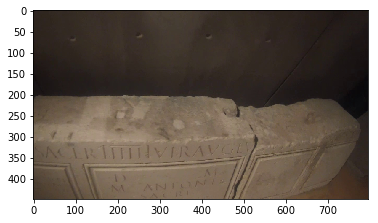

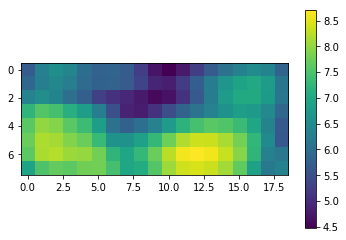

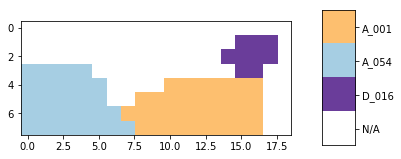

In [39]:
plt.imshow(sc(imread_rgb(test_img)))
# plt.savefig('sample1_10A-0519.png', bbox_inches='tight')

fig, ax = plt.subplots()
cax = ax.imshow(max_values, interpolation='nearest')
fig.colorbar(cax)
# plt.savefig('sample1_heatmap.png', bbox_inches='tight')

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1])
ax1 = plt.subplot(gs[0])
ax1.imshow(max_labels, cmap, interpolation='nearest')
ax2 = plt.subplot(gs[1])
ax2.imshow(labels_set[:, np.newaxis], cmap, interpolation='nearest')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().tick_right()
ax2.set_yticks(range(len(labels_set)))
ax2.set_yticklabels([labels[lab] if lab < len(labels) else 'N/A' for lab in labels_set])

# plt.savefig('sample1_labels.png', bbox_inches='tight')

In [35]:
class_net = TuneClassifSub(models.resnet152(pretrained=True), 464, (7, 7))
class_net.load_state_dict(torch.load('data/final_classif_sub/cli_resnet152.pth.tar'))
class_net = class_net.eval().cuda()

total, correct = 0, 0

for i, (im, lab, _) in enumerate(testSet):
    t = im.unsqueeze(0).cuda()
    out = class_net(Variable(t))[0].data
    max_pred, predicted = torch.max(out, 1)
    _, max_subp = torch.max(max_pred.view(-1), 0)
    predicted = predicted.view(-1)[max_subp[0]]
    total += 1
    correct += (labels.index(lab) == predicted)
    if labels.index(lab) != predicted:
        count = 0
        for j, (im, lab) in enumerate(testSetFull):
            if lab not in labels:
                count += 1
            if i + count == j:
                break
        print(lab, i, i + count, testSetFull[i + count])
print(correct, total)

('11C', 5, 5, ('data/pre_proc/CLICIDE_video_224sq/test/11C-0351.JPG', '11C'))
('11O', 9, 9, ('data/pre_proc/CLICIDE_video_224sq/test/11O-0438.JPG', '11O'))
('12D', 11, 11, ('data/pre_proc/CLICIDE_video_224sq/test/12D-0347.JPG', '12D'))
('12G', 16, 16, ('data/pre_proc/CLICIDE_video_224sq/test/12G-0428.JPG', '12G'))
('15F', 23, 23, ('data/pre_proc/CLICIDE_video_224sq/test/15F-0336.JPG', '15F'))
('16C', 25, 25, ('data/pre_proc/CLICIDE_video_224sq/test/16C-0343.JPG', '16C'))
('1C', 28, 28, ('data/pre_proc/CLICIDE_video_224sq/test/1C-0454.JPG', '1C'))
('1F', 29, 29, ('data/pre_proc/CLICIDE_video_224sq/test/1F-0452.JPG', '1F'))
('1R', 38, 38, ('data/pre_proc/CLICIDE_video_224sq/test/1R-0446.JPG', '1R'))
('20L', 44, 44, ('data/pre_proc/CLICIDE_video_224sq/test/20L-0731.JPG', '20L'))
('21D', 50, 50, ('data/pre_proc/CLICIDE_video_224sq/test/21D-0744.JPG', '21D'))
('22C', 52, 53, ('data/pre_proc/CLICIDE_video_224sq/test/22C-0814.JPG', '22C'))
('22D', 53, 54, ('data/pre_proc/CLICIDE_video_224sq/t